In [1]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

from pprint import PrettyPrinter
# Configure pretty printer
pp = PrettyPrinter(compact=True)
print_ = lambda x: pp.pprint(x)

In [2]:
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

from Utils.utils import PPT
from Config.config import PATHS
from Utils.utils import GetMeasurements
from Utils.interaction import Performer
from Utils.indices import AlternationIndex
from Utils.plot_utils import PlotVSMeasures
from Classes.cognitive_model_agents import (
    AttendanceM2, AttendanceM3, 
    MFPM2
)



## 2 Players

### Show AIC

In [3]:
file_2PL = PATHS['parameter_fit_results'] / Path('best_fit_2P.json')
df_2P = pd.read_json(file_2PL, lines=True)
df_2P.index = df_2P.model_name
df_parameters_2P = df_2P[['model_name', 'free_parameters']]
df_2P.drop(columns=['model', 'model_name', 'free_parameters', 'fixed_parameters'], inplace=True)
df_2P.sort_values(by='AIC', inplace=True)
# df_2P.sort_values(by='model_name', inplace=True)
df_2P['deviance'] = df_2P['deviance'].apply(lambda x: int(-x))
df_2P['AIC'] = df_2P['AIC'].apply(lambda x: int(x))
df_2P['AIC_diff'] = df_2P['AIC'] - df_2P['AIC'].min()
df_2P

,deviance,AIC,AIC_diff
model_name,,,
FRA+Payoff+Attendance,2223,4458,0
Attendance-M2,2253,4512,54
Attendance-M3,2253,4512,54
MFP-M2,2560,5125,667
MFP-M3,2560,5125,667
AvailableSpace-M2,2566,5138,680
AvailableSpace-M3,2566,5138,680
FRA,2716,5439,981
Fairness-M2,2791,5589,1131


In [4]:
latex_string = df_2P.to_latex()
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & deviance & AIC & AIC_diff \\
model_name &  &  &  \\
\midrule
FRA+Payoff+Attendance & 2223 & 4458 & 0 \\
Attendance-M2 & 2253 & 4512 & 54 \\
Attendance-M3 & 2253 & 4512 & 54 \\
MFP-M2 & 2560 & 5125 & 667 \\
MFP-M3 & 2560 & 5125 & 667 \\
AvailableSpace-M2 & 2566 & 5138 & 680 \\
AvailableSpace-M3 & 2566 & 5138 & 680 \\
FRA & 2716 & 5439 & 981 \\
Fairness-M2 & 2791 & 5589 & 1131 \\
Fairness-M3 & 2791 & 5589 & 1131 \\
Payoff-M2 & 2796 & 5597 & 1139 \\
Payoff-M3 & 2796 & 5597 & 1139 \\
WSLS-M2 & 2918 & 5843 & 1385 \\
WSLS-M3 & 2918 & 5843 & 1385 \\
Priors-M3 & 2968 & 5954 & 1496 \\
Priors-M2 & 2968 & 5962 & 1504 \\
Attendance-M1 & 3062 & 6130 & 1672 \\
Priors-M1 & 3133 & 6272 & 1814 \\
AvailableSpace-M1 & 3164 & 6335 & 1877 \\
MFP-M1 & 3166 & 6336 & 1878 \\
Payoff-M1 & 3177 & 6358 & 1900 \\
WSLS-M1 & 3182 & 6371 & 1913 \\
Fairness-M1 & 3188 & 6382 & 1924 \\
\bottomrule
\end{tabular}



In [4]:
from Utils.LaTeX_utils import PrintLaTeX

latex_string_parameters = ''

for model, row in df_parameters_2P.iterrows():
    if model in ['Attendance-M2', 'Fairness-M2', 'Payoff-M2']:
        parameters = row['free_parameters']
        print('-'*60)
        print(model)
        print(parameters)
        # latex_string_parameters += r'\textbf\{' + model + '\}\n'
        # latex_string_parameters += PrintLaTeX.print_parameters(parameters)

# print(latex_string_parameters)

------------------------------------------------------------
Payoff-M2
{'inverse_temperature': 6.3577853163, 'learning_rate': 0.0390547832}
------------------------------------------------------------
Attendance-M2
{'inverse_temperature': 6.154017841, 'learning_rate': 0.20037471880000002, 'bias': 0.7566579015}
------------------------------------------------------------
Fairness-M2
{'inverse_temperature': 3.4313704595, 'learning_rate': 0.0958919596, 'bias': 0.0}


### Simulate best fit model

In [ ]:
from Classes.cognitive_model_agents import Titan


def get_free_parameters(model_name, params_dict):
    model_names = df_parameters_2P['model_name'].tolist()
    idx = model_names.index(model_name)
    return df_parameters_2P['free_parameters'][idx]

# BEST_MODEL = MFPM2
# BEST_MODEL = AttendanceM2
BEST_MODEL = Titan

fixed_parameters = {
	"num_agents":2,
	"threshold":0.5,
}
free_parameters = {
    'inverse_temperature': 6, 
    'learning_rate': 0.16, 
    'bias': 0.78, 
    'len_history': 2, 
    'c': 0.91, 
    'delta': 0.1
}
simulation_parameters = {
	'num_rounds':50,
	'verbose':False
}

In [18]:
data_folder = PATHS['simulated_data']
num_episodes = 23 # same as human groups
random.seed(1)
seeds = [random.randint(0, 1000) for _ in range(num_episodes)]

Performer.simple_run(
    agent_class=BEST_MODEL,
    fixed_parameters=fixed_parameters,
    free_parameters=free_parameters,
    simulation_parameters=simulation_parameters,
    measures=[],
    data_folder=data_folder,
    new_file=False,
    seeds=seeds
)


Running seeds...:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Data saved to /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/simulated/FRA+Payoff+Attendance.csv


### Comparing with human data

<Axes: xlabel='inequality', ylabel='efficiency'>

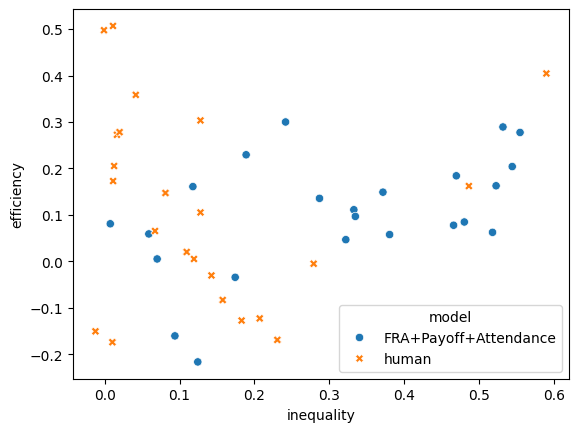

In [32]:
#Load 2P data
file_name = PATHS['human_data'] / '2-player-UR.csv'
data_human = pd.read_csv(file_name)
data_human['model'] = 'human'


file1 = PATHS['simulated_data'] / Path(f'{Titan.name()}.csv')
data_sim1 = pd.read_csv(file1)
data_sim1['model'] = Titan.name()

df = PPT.concat_dfs(data_human, data_sim1)

# Calculate alternation index per group
gm = GetMeasurements(
    data=df,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

image_file = PATHS['parameter_fit_results'] / 'two_way_comparisons_both.png'

df_jitter = df.copy()
df_jitter['efficiency'] = df['efficiency'] + np.random.normal(0, 0.01, len(df_jitter['efficiency']))
df_jitter['inequality'] = df['inequality'] + np.random.normal(0, 0.01, len(df_jitter['inequality']))

sns.scatterplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter
)

In [12]:
file1 = data_folder / Path(f'{Titan.name()}.csv')
data_sim1 = pd.read_csv(file1)
data_sim1['model'] = Titan.name()
file2 = data_folder / Path(f'{AttendanceM2.name()}.csv')
data_sim2 = pd.read_csv(file2)
data_sim2['model'] = AttendanceM2.name()

df = PPT.concat_dfs(data_human, data_sim1)
df = PPT.concat_dfs(df, data_sim2)

# Calculate alternation index per group
gm = GetMeasurements(
    data=df,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

image_file = PATHS['parameter_fit_results'] / 'two_way_comparisons_both.png'

df_jitter = df.copy()
df_jitter['efficiency'] = df['efficiency'] + np.random.normal(0, 0.01, len(df_jitter['efficiency']))
df_jitter['inequality'] = df['inequality'] + np.random.normal(0, 0.01, len(df_jitter['inequality']))

sns.scatterplot(
    x='inequality', y='efficiency',
    hue='model',style='model',
    data=df_jitter
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/simulated/Attendance-M2.csv'

## All sizes

### Show AIC

In [ ]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all_with_treatment.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

# Keep only deviance and AIC columns
df_all.drop(columns=['model_name', 'free_parameters'], inplace=True)
# df_all.sort_values(by='model_name', inplace=True)
df_all.sort_values(by='AIC', inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all

In [ ]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

# Keep only deviance and AIC columns
df_all.drop(columns=['model_name', 'free_parameters'], inplace=True)
# df_all.sort_values(by='model_name', inplace=True)
df_all.sort_values(by='AIC', inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all

### Simulate best fit model

In [ ]:
# Load data into a dataframe
data_folder = Path('..', 'data', 'human')
file_names = [
	'2-player-UR.csv',
	'3-player-IU.csv',
	'4-player-IU.csv',
	'5-player-IU.csv',
	'6-player-IU.csv',
	'7-player-IU.csv',
	'8-player-IU.csv',
	'9-player-IU.csv',
	'11-player-IU.csv',
	'12-player-IU.csv',
]
df_list = list()
for file_name in file_names:
	file = data_folder / Path(file_name)
	print(f'Loading data from {file}...')
	df = pd.read_csv(file)
	df_list.append(df)
data_human = pd.concat(df_list, ignore_index=True)
columns = ['threshold', 'num_players', 'group', 'round', 'player', 'score', 'decision']
drop_columns = [col for col in data_human.columns if col not in columns]
data_human.drop(columns=drop_columns, inplace=True)
data_human['model'] = 'human'

In [ ]:
list_fixed_parameters = PPT.get_fixed_parameters(data_human)
list_simulation_parameters = PPT.get_number_of_groups(data_human)
dict_update = {
    'num_rounds':50,
    'verbose':False
}
for sim_p in list_simulation_parameters:
    sim_p.update(dict_update)
num_groups = len(list_simulation_parameters)
print(f'{len(list_fixed_parameters)} fixed parameters and {len(list_simulation_parameters)} simulation parameters')

In [ ]:
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')

with open(file_all, 'r') as f:
    params_dict = json.load(f)

def get_free_parameters(model_name, params_dict):
    model_names = params_dict['model_name']
    idx = model_names.index(model_name)
    return params_dict['free_parameters'][idx]

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

free_parameters = get_free_parameters(BEST_MODEL.name(), params_dict)
print_(free_parameters)

In [ ]:
data_folder = PATHS['parameter_fit_results'] / Path('MLE')

for i in range(num_groups):
    fixed_parameters = list_fixed_parameters[i]
    simulation_parameters = list_simulation_parameters[i]
    print(f'Running {BEST_MODEL.name()} with')
    print('Fixed parameters:')
    print_(fixed_parameters)
    print('Simulation parameters:')
    print_(simulation_parameters)
    random.seed(1)
    num_episodes = simulation_parameters['num_episodes']    
    seeds = [random.randint(0, 1000) for _ in range(num_episodes)]
    Performer.simple_run(
        agent_class=BEST_MODEL,
        fixed_parameters=fixed_parameters,
        free_parameters=free_parameters,
        simulation_parameters=simulation_parameters,
        measures=[],
        data_folder=data_folder,
        seeds=seeds
    )

### Compare with human data

In [ ]:
# Loading simulated data

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

data_folder = PATHS['parameter_fit_results'] / Path('MLE')

df_list = list()
for i in range(num_groups):
    file = data_folder / Path(f'{BEST_MODEL.name()}_{i+1}.csv')
    # print(f'Loading data from {file}...')
    data_sim = pd.read_csv(file)
    data_sim['model'] = BEST_MODEL.name()
    df_list.append(data_sim)

data_sim = pd.concat(df_list, ignore_index=True)

df = PPT.concat_dfs(data_human, data_sim)

In [ ]:
p = PlotVSMeasures(df)
image_file = PATHS['parameter_fit_results'] / Path('MLE', f'two_way_comparisons_all.png')
measure_pairs = [['efficiency', 'attendance'], ['efficiency', 'inequality']]
p.two_way_comparisons(measure_pairs, image_file)

### Simulate treatments

In [ ]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

In [ ]:
# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2
# BEST_MODEL = AttendanceM3
free_parameters = df_parameters_all[BEST_MODEL.name()]
free_parameters

In [ ]:
fixed_parameters = {
    'num_agents': 8, 
    'threshold': 0 # to be filled
}
simulation_parameters = {
    'num_episodes': 30, 
    'num_rounds': 50, 
    'verbose': 0
}
thresholds = [0.25, 0.5, 0.75]
data_folder = PATHS['parameter_fit_results'] / Path('MLE')
kwargs = {
    'model_name': BEST_MODEL.name(),
}

In [ ]:
thresholds = [0.25, 0.5, 0.75]
kwargs = {
    'model_name': BEST_MODEL.name(),
    'with_treatment': True
}
Performer.increase_threshold(
    agent_class=BEST_MODEL,
    fixed_parameters=fixed_parameters,
    free_parameters=free_parameters,
    simulation_parameters=simulation_parameters,
    thresholds=thresholds,
    measures=['efficiency'],
    image_folder=data_folder,
    kwargs=kwargs
)

In [ ]:
# Load data into a dataframe
data_folder = Path('..', 'data', 'human')
file_names = [
#	'2-player-UR.csv',
	'3-player-IU.csv',
	'4-player-IU.csv',
	'5-player-IU.csv',
	'6-player-IU.csv',
	'7-player-IU.csv',
	'8-player-IU.csv',
	'9-player-IU.csv',
	'11-player-IU.csv',
	'12-player-IU.csv',
]
df_list = list()
for file_name in file_names:
	file = data_folder / Path(file_name)
	print(f'Loading data from {file}...')
	df = pd.read_csv(file)
	df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
columns = ['threshold', 'num_players', 'group', 'round', 'player', 'score', 'decision']
drop_columns = [col for col in data.columns if col not in columns]
data.drop(columns=drop_columns, inplace=True)
data.head()

In [ ]:
for key, grp in data.groupby('group'):
    print(f'Group {key}')
    print(f'Threshold: {grp["threshold"].unique()}')